In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import sem, t
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [3]:
data_path = 'F:/bishops/courseware/CS520/Project/Project_Work/database/Rest_Graphql_new(1).csv'
data = pd.read_csv(data_path)

In [4]:
data.head()

,Label,group,# Samples,Average,Min,Max,Std. Dev.,Error %,Throughput,Received KB/sec,Sent KB/sec,Avg. Bytes,Api_No,Category,Api
0,Rest,1,1,673,673,673,0.0,0.00%,1.48588,1.39,0.42,961.0,1,Animal,http://dog-api.kinduff.com/api/facts?number=5
1,Rest,1,1,320,320,320,0.0,0.00%,3.12500,11.02,0.80,3610.0,2,Animal,https://dog.ceo/api/breeds/list/all
2,Rest,1,1,150,150,150,0.0,0.00%,6.66667,134.75,1.60,20697.0,3,Animal,https://http.cat/status/200
3,Rest,1,1,74,74,74,0.0,0.00%,13.51351,27.49,1.79,2083.0,4,Animal,https://meowfacts.herokuapp.com/?count=3
4,Rest,1,1,367,367,367,0.0,0.00%,2.72480,46.62,0.67,17521.0,5,Animal,https://placebear.com/g/200/300


In [5]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Label            1500 non-null   object 
 1   group            1500 non-null   int64  
 2   # Samples        1500 non-null   int64  
 3   Average          1500 non-null   int64  
 4   Min              1500 non-null   int64  
 5   Max              1500 non-null   int64  
 6   Std. Dev.        1500 non-null   float64
 7   Error %          1500 non-null   object 
 8   Throughput       1500 non-null   float64
 9   Received KB/sec  1500 non-null   float64
 10  Sent KB/sec      1500 non-null   float64
 11  Avg. Bytes       1500 non-null   float64
 12  Api_No           1500 non-null   int64  
 13  Category         1495 non-null   object 
 14  Api              1500 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 175.9+ KB


In [ ]:
data.

RESTful API Confidence Intervals with Bootstrap:
# Samples
1         (812.6, 427.13466666666665, 1399.7186666666662)
20      (1435.6466666666668, 849.1010000000001, 2145.5...
50      (2091.266666666667, 1326.7571666666665, 3064.2...
100     (3707.8933333333334, 2210.362833333333, 5413.0...
1000    (59313.486666666664, 1548.8191666666667, 16615...
Name: Average, dtype: object
GraphQL API Confidence Intervals with Bootstrap:
# Samples
1       (203.96666666666667, 167.55516666666668, 244.6...
20        (260.4, 225.77683333333334, 296.40316666666666)
50      (671.6133333333333, 457.83133333333336, 926.96...
100       (1927.5, 1385.5283333333334, 2579.987333333333)
1000     (15787.54, 7949.163333333334, 28782.74533333333)
Name: Average, dtype: object


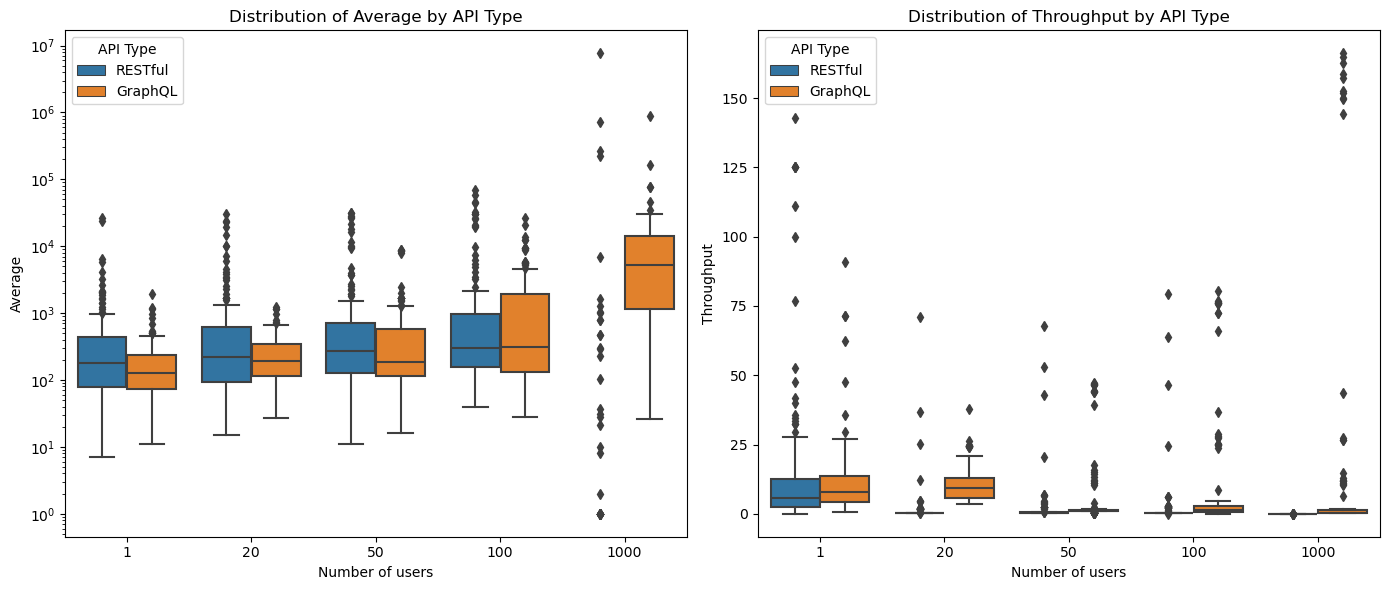

In [6]:
rest_apis = data[data['group'] == 1]
graphql_apis = data[data['group'] == 2]

# Functions to compute confidence intervals using bootstrap methods
def bootstrap_confidence_interval(data, n_bootstraps=1000, ci=95):
    """Calculate confidence interval for a sample data using bootstrap."""
    bootstrap_samples = np.array([resample(data) for _ in range(n_bootstraps)])
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    lower_bound = np.percentile(bootstrap_means, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrap_means, 100 - (100 - ci) / 2)
    return np.mean(data), lower_bound, upper_bound

# Apply bootstrap method to calculate confidence intervals
rest_conf_intervals = rest_apis.groupby('# Samples')['Average'].apply(bootstrap_confidence_interval)
graphql_conf_intervals = graphql_apis.groupby('# Samples')['Average'].apply(bootstrap_confidence_interval)

print("RESTful API Confidence Intervals with Bootstrap:")
print(rest_conf_intervals)
print("GraphQL API Confidence Intervals with Bootstrap:")
print(graphql_conf_intervals)

# Prepare plotting data
metrics = ['Average', 'Throughput']
data_for_plot = pd.concat([
    rest_apis.assign(API_Type='RESTful')[['# Samples', 'API_Type'] + metrics],
    graphql_apis.assign(API_Type='GraphQL')[['# Samples', 'API_Type'] + metrics]
])

# Plotting box plots and density maps
plt.figure(figsize=(14, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=data_for_plot, x='# Samples', y=metric, hue='API_Type')
    plt.title(f'Distribution of {metric} by API Type')
    plt.xlabel('Number of users')
    plt.ylabel(metric)
    plt.yscale('log' if metric == 'Average' else 'linear')
    plt.legend(title='API Type')
plt.tight_layout()
plt.show()



In [7]:
# Calculate percentile
percentiles = [90, 95, 99]
rest_percentiles = np.percentile(rest_apis['Average'], percentiles)
graphql_percentiles = np.percentile(graphql_apis['Average'], percentiles)

print("RESTful API Percentiles (90%, 95%, 99%):", rest_percentiles)
print("GraphQL API Percentiles (90%, 95%, 99%):", graphql_percentiles)

RESTful API Percentiles (90%, 95%, 99%): [ 2049.    9659.55 38182.39]
GraphQL API Percentiles (90%, 95%, 99%): [ 8676.7  14507.65 29074.15]


In [8]:
# Statistical significance tests of average respond time
u_stat, p_value = stats.mannwhitneyu(rest_apis['Average'], graphql_apis['Average'])
print("Mann-Whitney U test p-value:", p_value)

Mann-Whitney U test p-value: 4.6286897552229145e-12


In [9]:
rest_throughput_mean = rest_apis['Throughput'].mean()
graphql_throughput_mean = graphql_apis['Throughput'].mean()

# Mann-Whitney U test comparing throughput rates
u_stat_throughput, p_value_throughput = stats.mannwhitneyu(rest_apis['Throughput'], graphql_apis['Throughput'])

print("RESTful API Average Throughput:", rest_throughput_mean)
print("GraphQL API Average Throughput:", graphql_throughput_mean)
print("Mann-Whitney U test p-value:", p_value_throughput)

RESTful API Average Throughput: 4.017793093333333
GraphQL API Average Throughput: 9.536951626666667
Mann-Whitney U test p-value: 3.810719516233757e-83


In [10]:
# Average of error rates
rest_error_rate_mean = rest_apis['Error %'].replace('%', '', regex=True).astype(float).mean()
graphql_error_rate_mean = graphql_apis['Error %'].replace('%', '', regex=True).astype(float).mean()

# Mann-Whitney U test comparing error rates
u_stat_error, p_value_error = stats.mannwhitneyu(
    rest_apis['Error %'].replace('%', '', regex=True).astype(float),
    graphql_apis['Error %'].replace('%', '', regex=True).astype(float)
)

print("RESTful API Average Error Rate:", rest_error_rate_mean)
print("GraphQL API Average Error Rate:", graphql_error_rate_mean)
print("Mann-Whitney U test p-value:", p_value_error)

RESTful API Average Error Rate: 22.784319999999997
GraphQL API Average Error Rate: 19.73312
Mann-Whitney U test p-value: 0.12107101050919478


In [11]:
# Calculate average receive and transmit KB/sec
rest_received_mean = rest_apis['Received KB/sec'].mean()
graphql_received_mean = graphql_apis['Received KB/sec'].mean()
rest_sent_mean = rest_apis['Sent KB/sec'].mean()
graphql_sent_mean = graphql_apis['Sent KB/sec'].mean()

# Mann-Whitney U test comparing data reception and transmission efficiency
u_stat_received, p_value_received = stats.mannwhitneyu(rest_apis['Received KB/sec'], graphql_apis['Received KB/sec'])
u_stat_sent, p_value_sent = stats.mannwhitneyu(rest_apis['Sent KB/sec'], graphql_apis['Sent KB/sec'])

print("RESTful API Average Received KB/sec:", rest_received_mean)
print("GraphQL API Average Received KB/sec:", graphql_received_mean)
print("RESTful API Average Sent KB/sec:", rest_sent_mean)
print("GraphQL API Average Sent KB/sec:", graphql_sent_mean)
print("Received Data Mann-Whitney U test p-value:", p_value_received)
print("Sent Data Mann-Whitney U test p-value:", p_value_sent)

RESTful API Average Received KB/sec: 90.42678666666666
GraphQL API Average Received KB/sec: 190.36276
RESTful API Average Sent KB/sec: 0.6464666666666666
GraphQL API Average Sent KB/sec: 5.53832
Received Data Mann-Whitney U test p-value: 5.409561089005757e-40
Sent Data Mann-Whitney U test p-value: 3.0834416139966266e-101


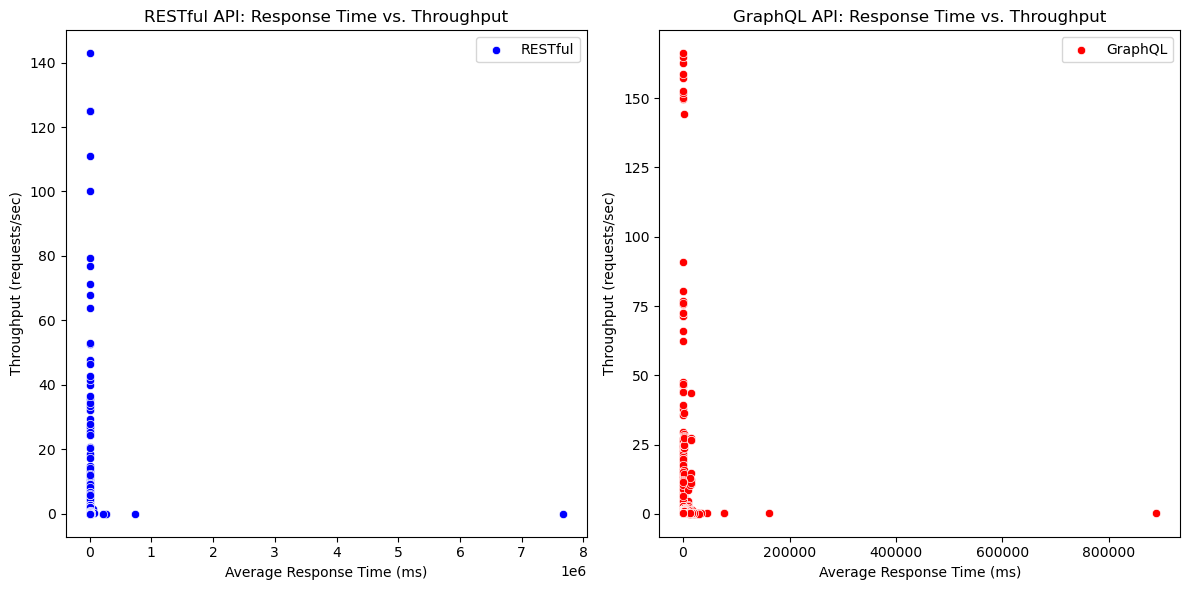

RESTful API Correlation between Response Time and Throughput: -0.012875131737988797
GraphQL API Correlation between Response Time and Throughput: -0.039830367774647456


In [12]:
# Scatterplot showing response time vs. throughput rate
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Average', y='Throughput', data=rest_apis, color='blue', label='RESTful')
plt.title('RESTful API: Response Time vs. Throughput')
plt.xlabel('Average Response Time (ms)')
plt.ylabel('Throughput (requests/sec)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Average', y='Throughput', data=graphql_apis, color='red', label='GraphQL')
plt.title('GraphQL API: Response Time vs. Throughput')
plt.xlabel('Average Response Time (ms)')
plt.ylabel('Throughput (requests/sec)')

plt.tight_layout()
plt.show()

# Calculate the correlation coefficient
rest_corr = rest_apis['Average'].corr(rest_apis['Throughput'])
graphql_corr = graphql_apis['Average'].corr(graphql_apis['Throughput'])
print("RESTful API Correlation between Response Time and Throughput:", rest_corr)
print("GraphQL API Correlation between Response Time and Throughput:", graphql_corr)

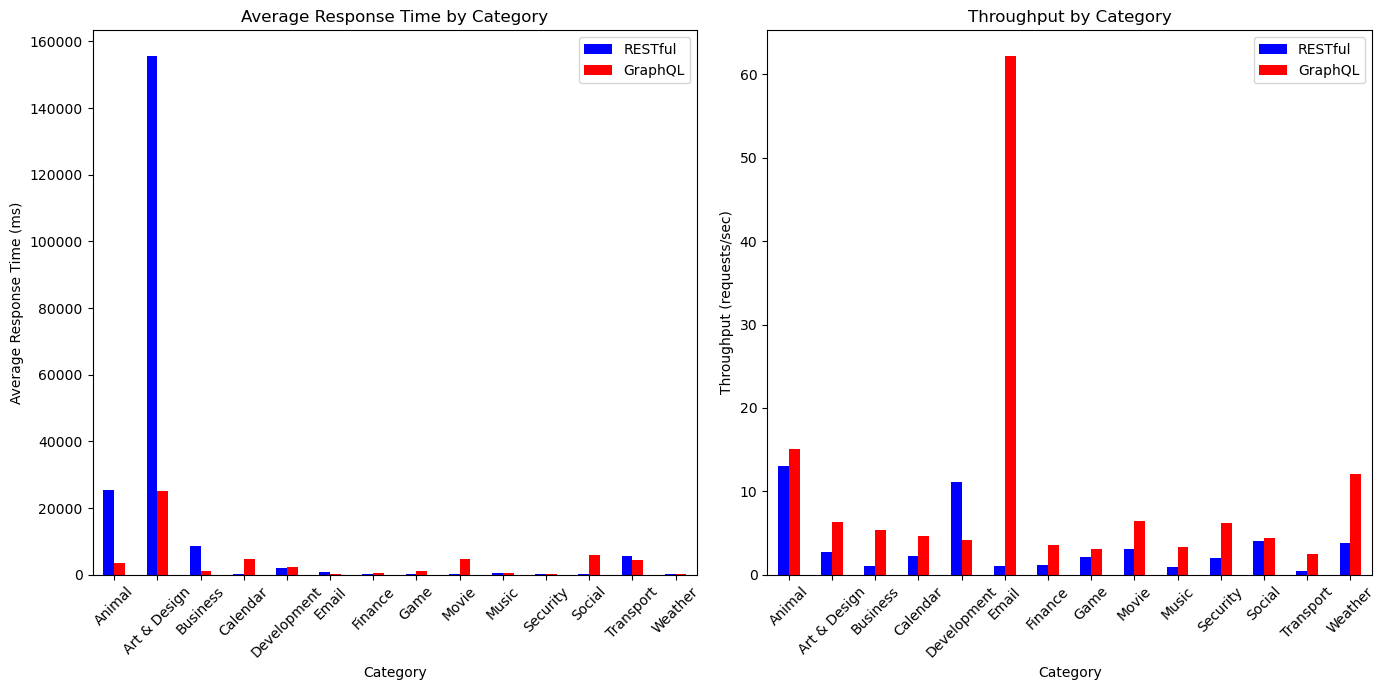

In [13]:
category_performance = data.groupby(['group', 'Category'])[['Average', 'Throughput']].mean().unstack(0)

# Create subgraph grids
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Visualization of response time
category_performance['Average'].plot(kind='bar', color=['blue', 'red'], ax=axes[0])
axes[0].set_title('Average Response Time by Category')
axes[0].set_ylabel('Average Response Time (ms)')
axes[0].set_xlabel('Category')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(['RESTful', 'GraphQL'])

# Visualization throughput rate
category_performance['Throughput'].plot(kind='bar', color=['blue', 'red'], ax=axes[1])
axes[1].set_title('Throughput by Category')
axes[1].set_ylabel('Throughput (requests/sec)')
axes[1].set_xlabel('Category')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(['RESTful', 'GraphQL'])

plt.tight_layout()
plt.show()

In [14]:
# Data cleaning
data['Error %'] = data['Error %'].str.rstrip('%').astype('float') / 100.0
data['Category'].fillna("Unknown", inplace=True)

# Standardized processing
scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[['Average', 'Throughput', 'Std. Dev.', 'Error %', 'Received KB/sec', 'Sent KB/sec']] = scaler.fit_transform(
    data[['Average', 'Throughput', 'Std. Dev.', 'Error %', 'Received KB/sec', 'Sent KB/sec']]
)

# Selection of characteristics and target variables
features = data_scaled[['Average', 'Std. Dev.', 'Error %', 'Received KB/sec', 'Sent KB/sec']]
target = data_scaled['Throughput']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Creating a Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# train
rf_model.fit(X_train, y_train)

# Forecasting and assessment
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Access to feature significance
feature_importances = rf_model.feature_importances_

# Mean Square Error and Characteristic Importance of Printed Models
print("Mean Squared Error:", mse)
print("Feature Importances:", feature_importances)

Mean Squared Error: 0.0007067169001579534
Feature Importances: [0.13499701 0.02359821 0.06910088 0.10003298 0.67227092]


In [15]:
def recommend_api(data_scaled, category, user_num):
    filtered_data = data_scaled[data_scaled['Category'].str.lower() == category.lower()]
    if filtered_data.empty:
        return "not found for the specified category。"

    # Calculate adjusted score using weights obtained from machine learning
    filtered_data['Adjusted Score'] = (
        -1.0 * filtered_data['Average'] * 0.4052 +
        -1.0 * filtered_data['Std. Dev.'] * 0.0132 +
        -1.0 * filtered_data['Error %'] * 0.0015 +
        filtered_data['Received KB/sec'] * 0.0285 +
        filtered_data['Sent KB/sec'] * 0.5516
    )

    closest_user_num = filtered_data.iloc[(filtered_data['# Samples'] - user_num).abs().argsort()[:1]]
    top_api = closest_user_num.sort_values(by='Adjusted Score', ascending=False).iloc[0]
    return {
        'API Label': top_api['Label'],
        'API Group': 'RESTful' if top_api['group'] == 1 else 'GraphQL',
        'API Number': top_api['Api_No'],
        'Recommended for User Number': top_api['# Samples'],
        'Adjusted Score': top_api['Adjusted Score']
    }

In [18]:
def main():
    category = input("Please enter your API category: ")
    user_num = int(input("Please enter your target number of users: "))
    result = recommend_api(data_scaled, category, user_num)
    print("\n Recommended API details are as follows: ")
    for key, value in result.items():
        print(f"{key}: {value}")

if __name__ == "__main__":
    main()

Please enter your API category:  email
Please enter your target number of users:  10



 Recommended API details are as follows: 
API Label: Rest
API Group: RESTful
API Number: 61
Recommended for User Number: 1
Adjusted Score: 0.0009576115228661024


C:\Users\aless\AppData\Local\Temp\ipykernel_37880\2256206898.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Adjusted Score'] = (
